In [6]:
# Raw Clustering

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv('cancer_data.csv')

# Normalize year
df['Year'] = 2025 - df['Year']

# Encode the combined labels
label_encoder = LabelEncoder()
df['Cancer_Stage_Int'] = label_encoder.fit_transform(df['Cancer_Stage'])

# Save mapping (optional)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# One-hot encode categorical features
categorical_cols = ['Gender','Country_Region'] 
X = pd.get_dummies(df, columns=categorical_cols)

# For performance reasons I need to drop this to first 1000 rows only
X = X.iloc[:1000]

# Drop original target columns
Y = X['Cancer_Type']
X = X.drop(['Patient_ID', 'Cancer_Stage', 'Cancer_Type'], axis=1)  # drop ID and target
X = X.replace({'True': 1, 'False': 0}) # Replace true and false with int representations

# Save to CSV
X.to_csv("filtered_cancer_data.csv", index=False)
Y.to_csv("filtered_cancer_outcome.csv", index=False)



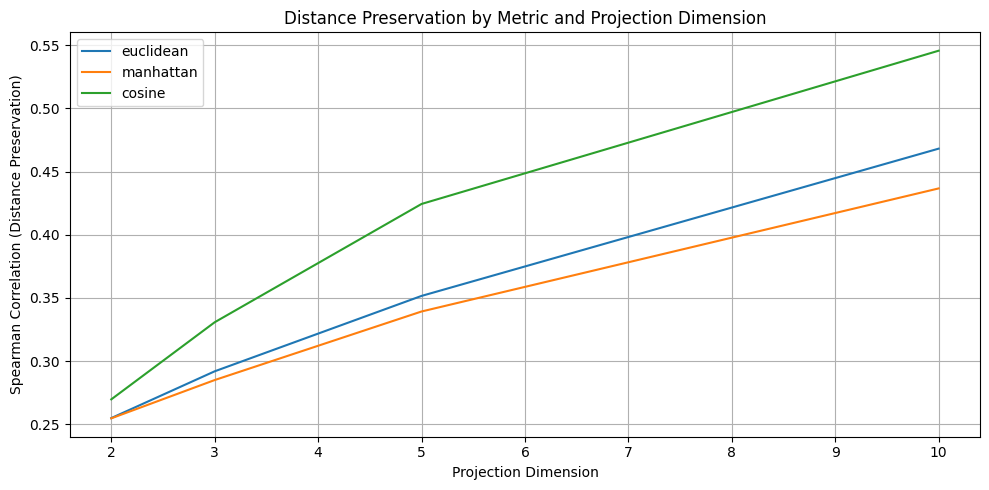

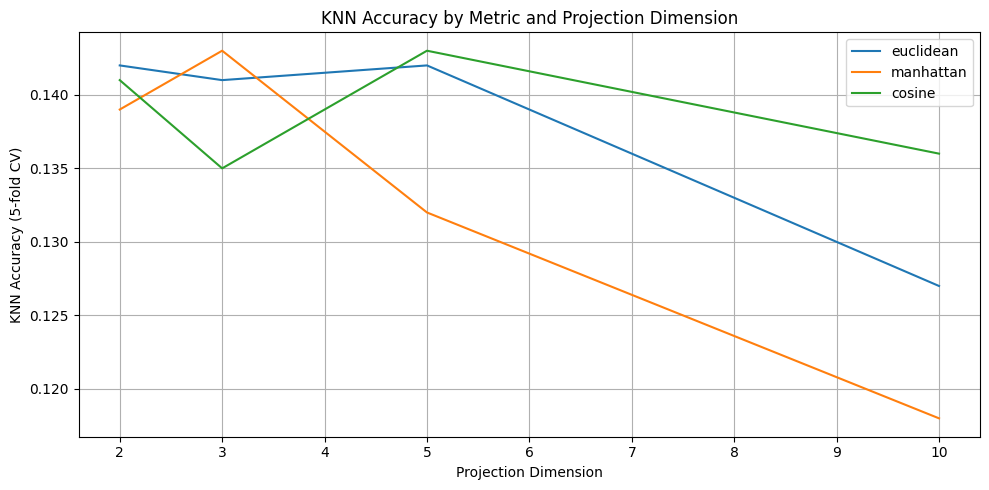


Best projection: 3D with 'manhattan' metric → KNN Accuracy = 0.1430
Best configuration saved to 'Cancer_best_random_projection_config.json'
Best projected data saved to 'Cancer_best_random_projection_data.csv'


In [7]:
# Randomized Projections
# Randomized Projections with Chunked Pairwise Distances

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import pairwise_distances, pairwise_distances_chunked
from scipy.stats import spearmanr
import json

# Load and standardize data
X = pd.read_csv('filtered_cancer_data.csv')
Y = pd.read_csv('filtered_cancer_outcome.csv').iloc[:, 0]
X = StandardScaler().fit_transform(X)

# Configurations
dims_list = [2, 3, 5, 10]
distance_metrics = ['euclidean', 'manhattan', 'cosine']

# Storage
distance_corr_results = []
knn_accuracy_results = []

# Precompute original distances (not chunked, because only done once per metric)
original_dists = {
    metric: pairwise_distances(X, metric=metric).ravel()
    for metric in distance_metrics
}

# Helper for chunked distance + Spearman correlation
def compute_spearman_corr_with_chunked(X_proj, metric, ref_dists):
    proj_dists = []
    for chunk in pairwise_distances_chunked(X_proj, metric=metric, n_jobs=-1, working_memory=1024):
        proj_dists.append(chunk.ravel())
    proj_dists_flat = np.concatenate(proj_dists)
    corr, _ = spearmanr(ref_dists, proj_dists_flat)
    return corr

# Main loop
for n in dims_list:
    rp = GaussianRandomProjection(n_components=n, random_state=43)
    X_proj = rp.fit_transform(X)

    for metric in distance_metrics:
        # Distance preservation
        try:
            corr = compute_spearman_corr_with_chunked(X_proj, metric, original_dists[metric])
        except Exception as e:
            print(f"Distance calc failed for dims={n}, metric={metric}: {e}")
            corr = np.nan
        distance_corr_results.append((n, metric, corr))

        # KNN accuracy
        clf = KNeighborsClassifier(n_neighbors=10, metric=metric)
        try:
            acc = cross_val_score(clf, X_proj, Y, cv=5).mean()
        except ValueError:
            acc = np.nan
        knn_accuracy_results.append((n, metric, acc))

# Convert to structured arrays for plotting
def extract_by_metric(results, metric):
    dims = [r[0] for r in results if r[1] == metric]
    values = [r[2] for r in results if r[1] == metric]
    return dims, values

# Plot: Distance Preservation
plt.figure(figsize=(10, 5))
for metric in distance_metrics:
    dims, corrs = extract_by_metric(distance_corr_results, metric)
    plt.plot(dims, corrs, label=f"{metric}")
plt.xlabel("Projection Dimension")
plt.ylabel("Spearman Correlation (Distance Preservation)")
plt.title("Distance Preservation by Metric and Projection Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Cancer_Random_Projection_Spearman.png", bbox_inches='tight')
plt.show()

# Plot: KNN Accuracy
plt.figure(figsize=(10, 5))
for metric in distance_metrics:
    dims, accs = extract_by_metric(knn_accuracy_results, metric)
    plt.plot(dims, accs, label=f"{metric}")
plt.xlabel("Projection Dimension")
plt.ylabel("KNN Accuracy (5-fold CV)")
plt.title("KNN Accuracy by Metric and Projection Dimension")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Cancer_Random_Projection_KNN_acc.png", bbox_inches='tight')
plt.show()

# Find best (dimension, metric) pair by KNN accuracy
valid_results = [r for r in knn_accuracy_results if not np.isnan(r[2])]
best = max(valid_results, key=lambda x: x[2])
best_dims, best_metric, best_acc = best

# Print and save best configuration
print(f"\nBest projection: {best_dims}D with '{best_metric}' metric → KNN Accuracy = {best_acc:.4f}")
best_config = {
    "n_components": best_dims,
    "distance_metric": best_metric,
    "knn_accuracy": best_acc
}
with open("Cancer_best_random_projection_config.json", "w") as f:
    json.dump(best_config, f, indent=4)
print("Best configuration saved to 'Cancer_best_random_projection_config.json'")

# Recreate the best projection and save to CSV
best_rp = GaussianRandomProjection(n_components=best_dims, random_state=42)
X_best_proj = best_rp.fit_transform(X)

df_proj = pd.DataFrame(X_best_proj, columns=[f"RP_Component_{i+1}" for i in range(best_dims)])
df_proj.to_csv("Cancer_best_random_projection_data.csv", index=False)
print("Best projected data saved to 'Cancer_best_random_projection_data.csv'")


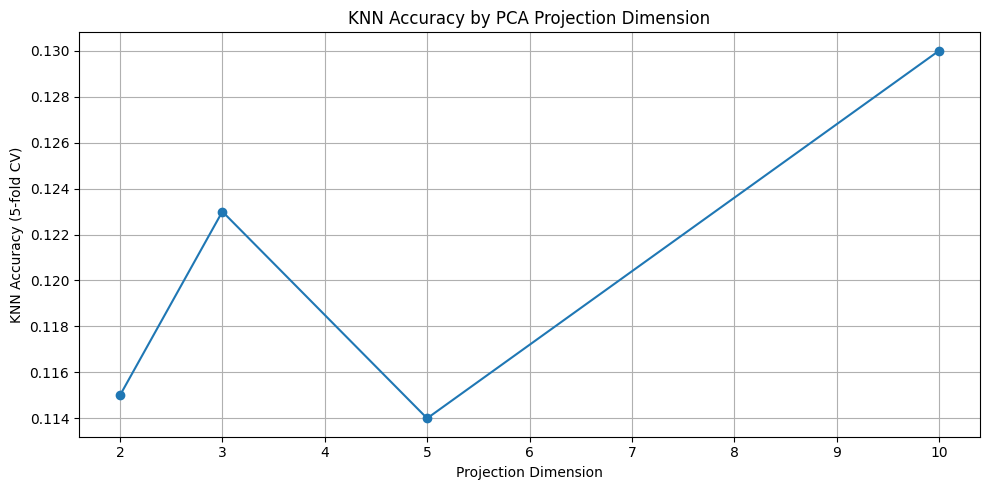

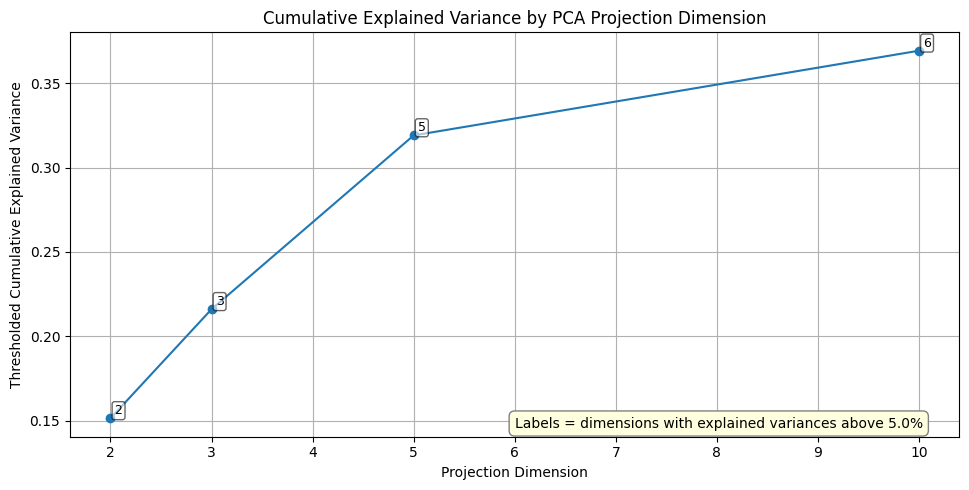


Best PCA projection: 10D → KNN Accuracy = 0.1300
Best configuration saved to 'Cancer_best_pca_config.json'
Best PCA projected data saved to 'Cancer_best_pca_data.csv'


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
import json

# Load and standardize data
X = pd.read_csv('filtered_cancer_data.csv')
Y = pd.read_csv('filtered_cancer_outcome.csv').iloc[:, 0]

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Configurations
dims_list = [2, 3, 5, 10]

# Storage for KNN accuracy results
knn_accuracy_results = []

# Define cutoff threshold (e.g., stop summing if a component explains <1% of variance)
min_threshold = 0.05 # Use 5% since 5% would be generally accepted signifigance value
# Cumulative Variance
exp_variance_results = []

# Main loop over projection dimensions
for n in dims_list:
    pca = PCA(n_components=n, random_state=42)
    X_proj = pca.fit_transform(X_scaled)

    explained_variance_ratios = pca.explained_variance_ratio_
    
    # Sum component contributions above the threshold
    cutoff_index = 0
    cumulative = 0.0
    for i, var in enumerate(explained_variance_ratios):
        if var > min_threshold:
            cutoff_index += 1
            cumulative += var
    

    exp_variance_results.append((n, cutoff_index, cumulative))
    

    # KNN accuracy
    clf = KNeighborsClassifier(n_neighbors=10)
    acc = cross_val_score(clf, X_proj, Y, cv=5).mean()
    knn_accuracy_results.append((n, acc))

# Plot: KNN Accuracy
dims, accs = zip(*knn_accuracy_results)
plt.figure(figsize=(10, 5))
plt.plot(dims, accs, marker='o')
plt.xlabel("Projection Dimension")
plt.ylabel("KNN Accuracy (5-fold CV)")
plt.title("KNN Accuracy by PCA Projection Dimension")
plt.grid(True)
plt.tight_layout()
plt.savefig("Cancer_PCA_KNN_acc.png", bbox_inches='tight')
plt.show()


# Plot: Explained Variance
dims, cutoff, exp_var = zip(*exp_variance_results)
plt.figure(figsize=(10, 5))
plt.plot(dims, exp_var, marker='o')
plt.xlabel("Projection Dimension")
plt.ylabel("Thresholded Cumulative Explained Variance")
plt.title("Cumulative Explained Variance by PCA Projection Dimension")
plt.grid(True)

# Annotate each point with cutoff index
for x, y, c in zip(dims, exp_var, cutoff):
    plt.annotate(f"{c}", xy=(x, y), xytext=(3, 3),
                 textcoords='offset points', fontsize=9,
                 bbox=dict(boxstyle="round,pad=0.2", fc="white", alpha=0.6))
# Explainer Text
plt.text(0.5, 0.05,
         f"Labels = dimensions with explained variances above {min_threshold * 100}%",
         transform=plt.gca().transAxes,
         fontsize=10,
         verticalalignment='top',
         bbox=dict(boxstyle="round,pad=0.4", fc="lightyellow", ec="gray"))

plt.tight_layout()
plt.savefig("Cancer_PCA_Exp_Var.png", bbox_inches='tight')
plt.show()

# Find best dimension by KNN accuracy
best_dims, best_acc = max(knn_accuracy_results, key=lambda x: x[1])

# Print and save best configuration
print(f"\nBest PCA projection: {best_dims}D → KNN Accuracy = {best_acc:.4f}")
best_config = {
    "n_components": best_dims,
    "knn_accuracy": best_acc,
    "cutoff_component_index": cutoff_index,
    "cumulative_explained_variance": round(cumulative, 4),
    "threshold": min_threshold
}
with open("Cancer_best_pca_config.json", "w") as f:
    json.dump(best_config, f, indent=4)
print("Best configuration saved to 'Cancer_best_pca_config.json'")

# Recreate the best projection and save to CSV
best_pca = PCA(n_components=best_dims, random_state=42)
X_best_proj = best_pca.fit_transform(X_scaled)

# Save to CSV
df_proj = pd.DataFrame(X_best_proj, columns=[f"PCA_Component_{i+1}" for i in range(best_dims)])
df_proj.to_csv("Cancer_best_pca_data.csv", index=False)

print("Best PCA projected data saved to 'Cancer_best_pca_data.csv'")


2D → KNN Acc = 0.1160, Avg MI = 0.0017
3D → KNN Acc = 0.1150, Avg MI = 0.2030
5D → KNN Acc = 0.1170, Avg MI = 0.0924
10D → KNN Acc = 0.1200, Avg MI = 0.0595


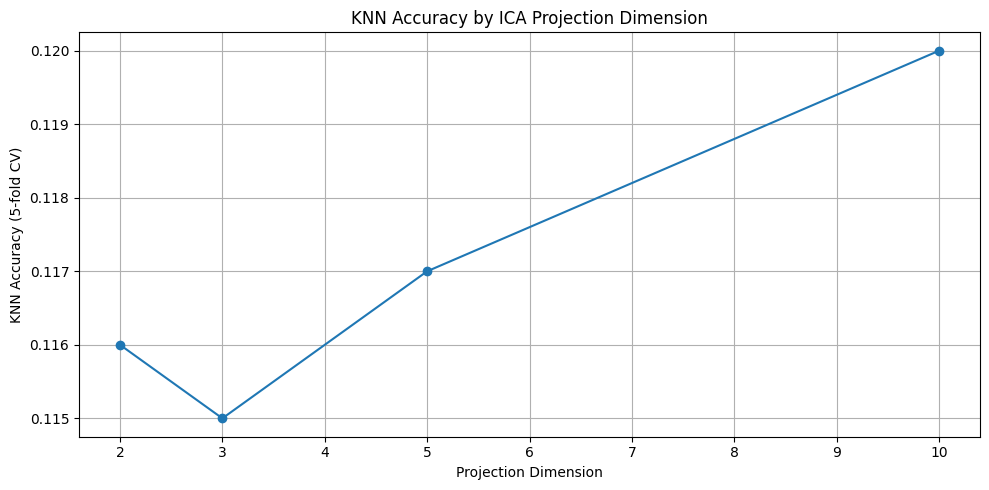

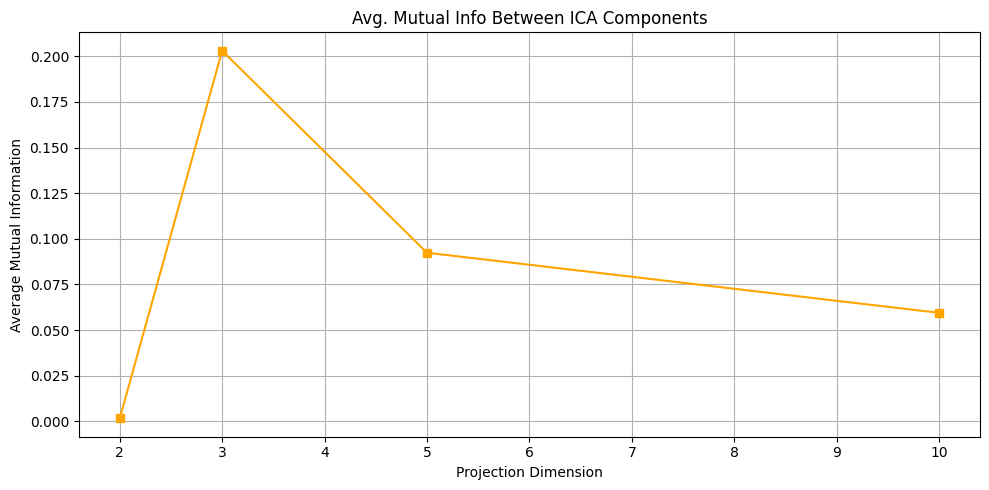


Best ICA projection: 10D → KNN Accuracy = 0.1200, Avg MI = 0.0595
Best configuration saved to 'Cancer_best_ica_config.json'
Best ICA projected data saved to 'Cancer_best_ica_data.csv'


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import mutual_info_regression
import json

# Load and standardize data
X = pd.read_csv('filtered_cancer_data.csv')
Y = pd.read_csv('filtered_cancer_outcome.csv').iloc[:, 0]

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# Configurations
dims_list = [2, 3, 5, 10]

# Storage for results
results = []

# Main loop over projection dimensions
for n in dims_list:
    try:
        ica = FastICA(n_components=n, random_state=42)
        X_proj = ica.fit_transform(X_scaled)

        # KNN accuracy
        clf = KNeighborsClassifier(n_neighbors=10)
        acc = cross_val_score(clf, X_proj, Y, cv=5).mean()

        # Mutual information between ICA components
        mi_scores = []
        for i in range(X_proj.shape[1]):
            for j in range(i + 1, X_proj.shape[1]):
                mi = mutual_info_regression(X_proj[:, [i]], X_proj[:, j])[0]
                mi_scores.append(mi)
        avg_mi = np.mean(mi_scores)

        results.append({
            "n_components": n,
            "knn_accuracy": acc,
            "avg_mutual_info": avg_mi
        })
        print(f"{n}D → KNN Acc = {acc:.4f}, Avg MI = {avg_mi:.4f}")
    except Exception as e:
        print(f"Skipped dimension {n}: {e}")

# Plot: KNN Accuracy
if results:
    dims = [r["n_components"] for r in results]
    accs = [r["knn_accuracy"] for r in results]
    mis = [r["avg_mutual_info"] for r in results]

    # Accuracy plot
    plt.figure(figsize=(10, 5))
    plt.plot(dims, accs, marker='o', label='KNN Accuracy')
    plt.xlabel("Projection Dimension")
    plt.ylabel("KNN Accuracy (5-fold CV)")
    plt.title("KNN Accuracy by ICA Projection Dimension")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Cancer_ICA_KNN_acc.png", bbox_inches='tight')
    plt.show()

    # MI plot
    plt.figure(figsize=(10, 5))
    plt.plot(dims, mis, marker='s', color='orange', label='Average Mutual Information')
    plt.xlabel("Projection Dimension")
    plt.ylabel("Average Mutual Information")
    plt.title("Avg. Mutual Info Between ICA Components")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("Cancer_ICA_MI.png", bbox_inches='tight')
    plt.show()

    # Find best dimension by KNN accuracy
    best_result = max(results, key=lambda r: r["knn_accuracy"])
    best_dims = best_result["n_components"]
    best_acc = best_result["knn_accuracy"]

    # Save best config
    best_config = {
        "n_components": best_dims,
        "knn_accuracy": best_acc,
        "avg_mutual_info": best_result["avg_mutual_info"]
    }
    with open("Cancer_best_ica_config.json", "w") as f:
        json.dump(best_config, f, indent=4)
    print(f"\nBest ICA projection: {best_dims}D → KNN Accuracy = {best_acc:.4f}, Avg MI = {best_result['avg_mutual_info']:.4f}")
    print("Best configuration saved to 'Cancer_best_ica_config.json'")

    # Recreate and save the best projection
    best_ica = FastICA(n_components=best_dims, random_state=42)
    X_best_proj = best_ica.fit_transform(X_scaled)
    df_proj = pd.DataFrame(X_best_proj, columns=[f"ICA_Component_{i+1}" for i in range(best_dims)])
    df_proj.to_csv("Cancer_best_ica_data.csv", index=False)
    print("Best ICA projected data saved to 'Cancer_best_ica_data.csv'")
else:
    print("No valid ICA projections were computed.")
